### EDA
#### Step 1 : 分析各產業別之間的異常報酬率

In [1]:
import pandas as pd
import seaborn as sns
import bokeh as bok
df_fs_return=pd.read_csv("上市櫃公司_plus異常報酬率.csv")

In [3]:
import numpy as np
df_fs_return_columns=df_fs_return.columns[51:]
return_industry=df_fs_return.groupby(by="TSE產業名稱")[df_fs_return_columns].mean()
print("資料集大小 :",return_industry.shape)
print(f"總計有{len(np.unique(df_fs_return['TSE產業名稱'].values.flatten()))}種產業類別")

資料集大小 : (35, 132)
總計有35種產業類別


### 動態圖表 : 完全由Gemini pro 3 製作

#### df.melt() = 將寬資料轉換成長資料，以符合製圖模組的需求
#### 使用說明 :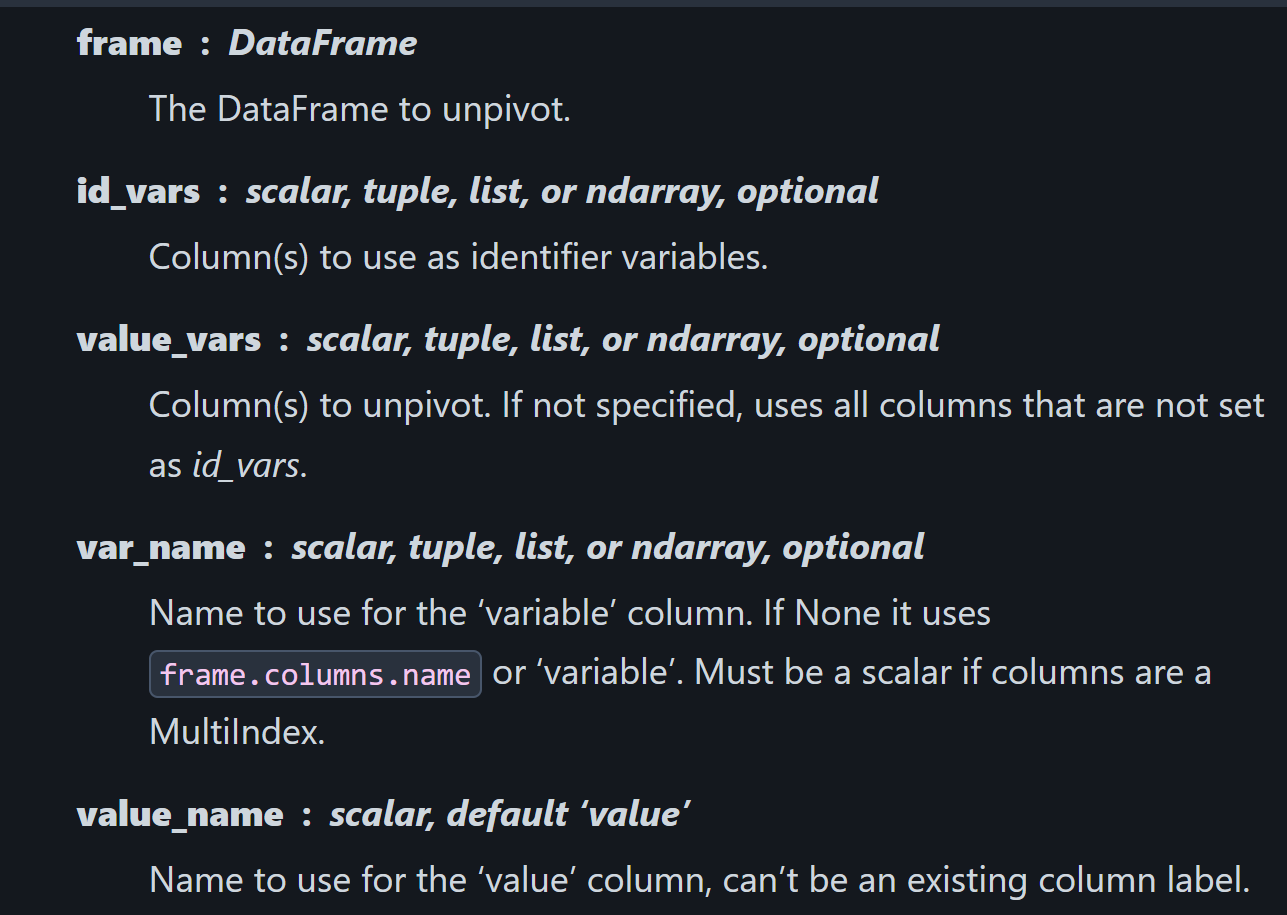
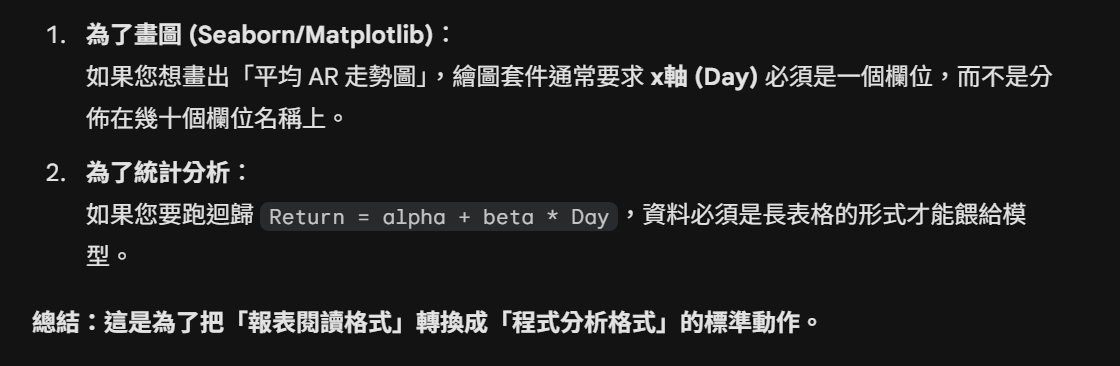
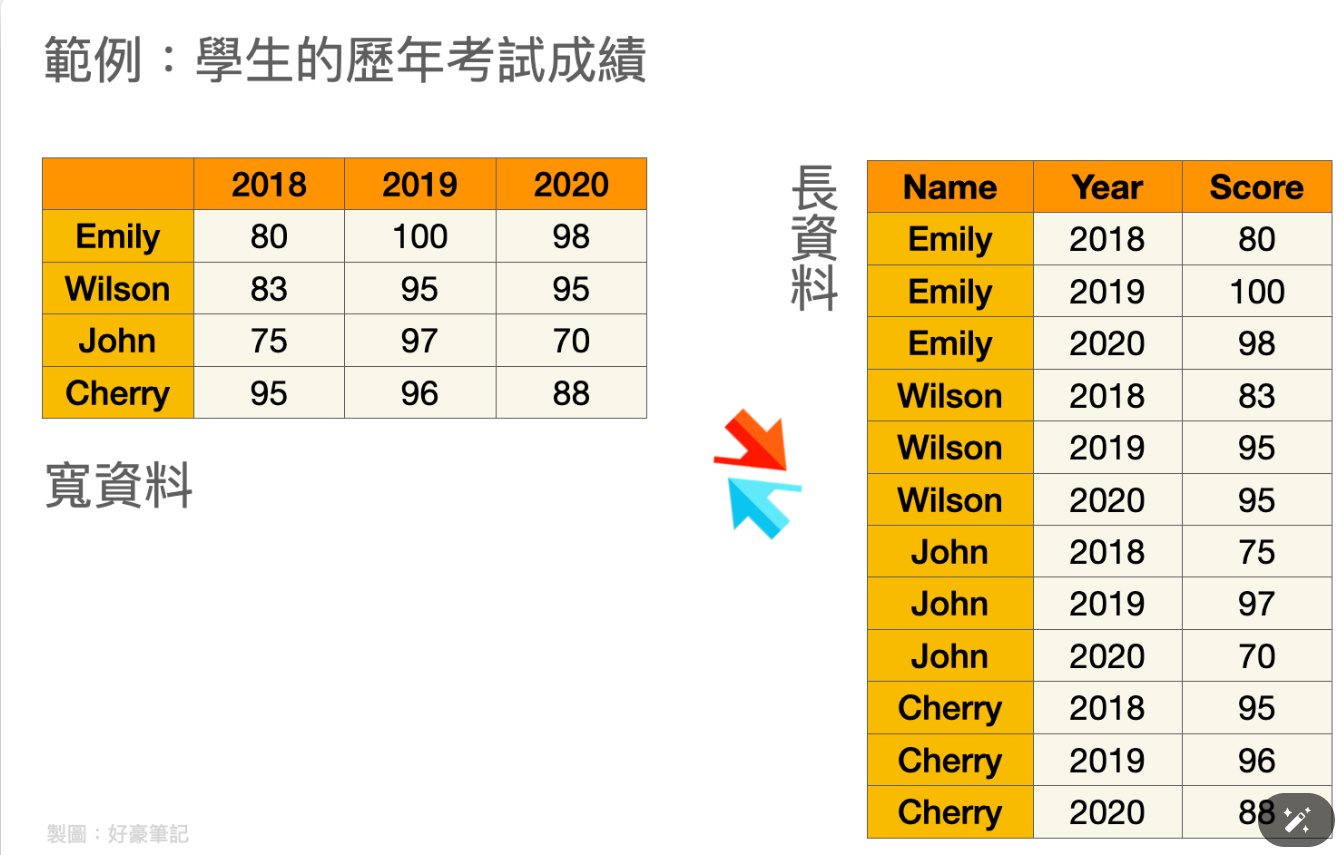
#### <span style="color : #2c5344"> px.colors.qualitative函式內容:
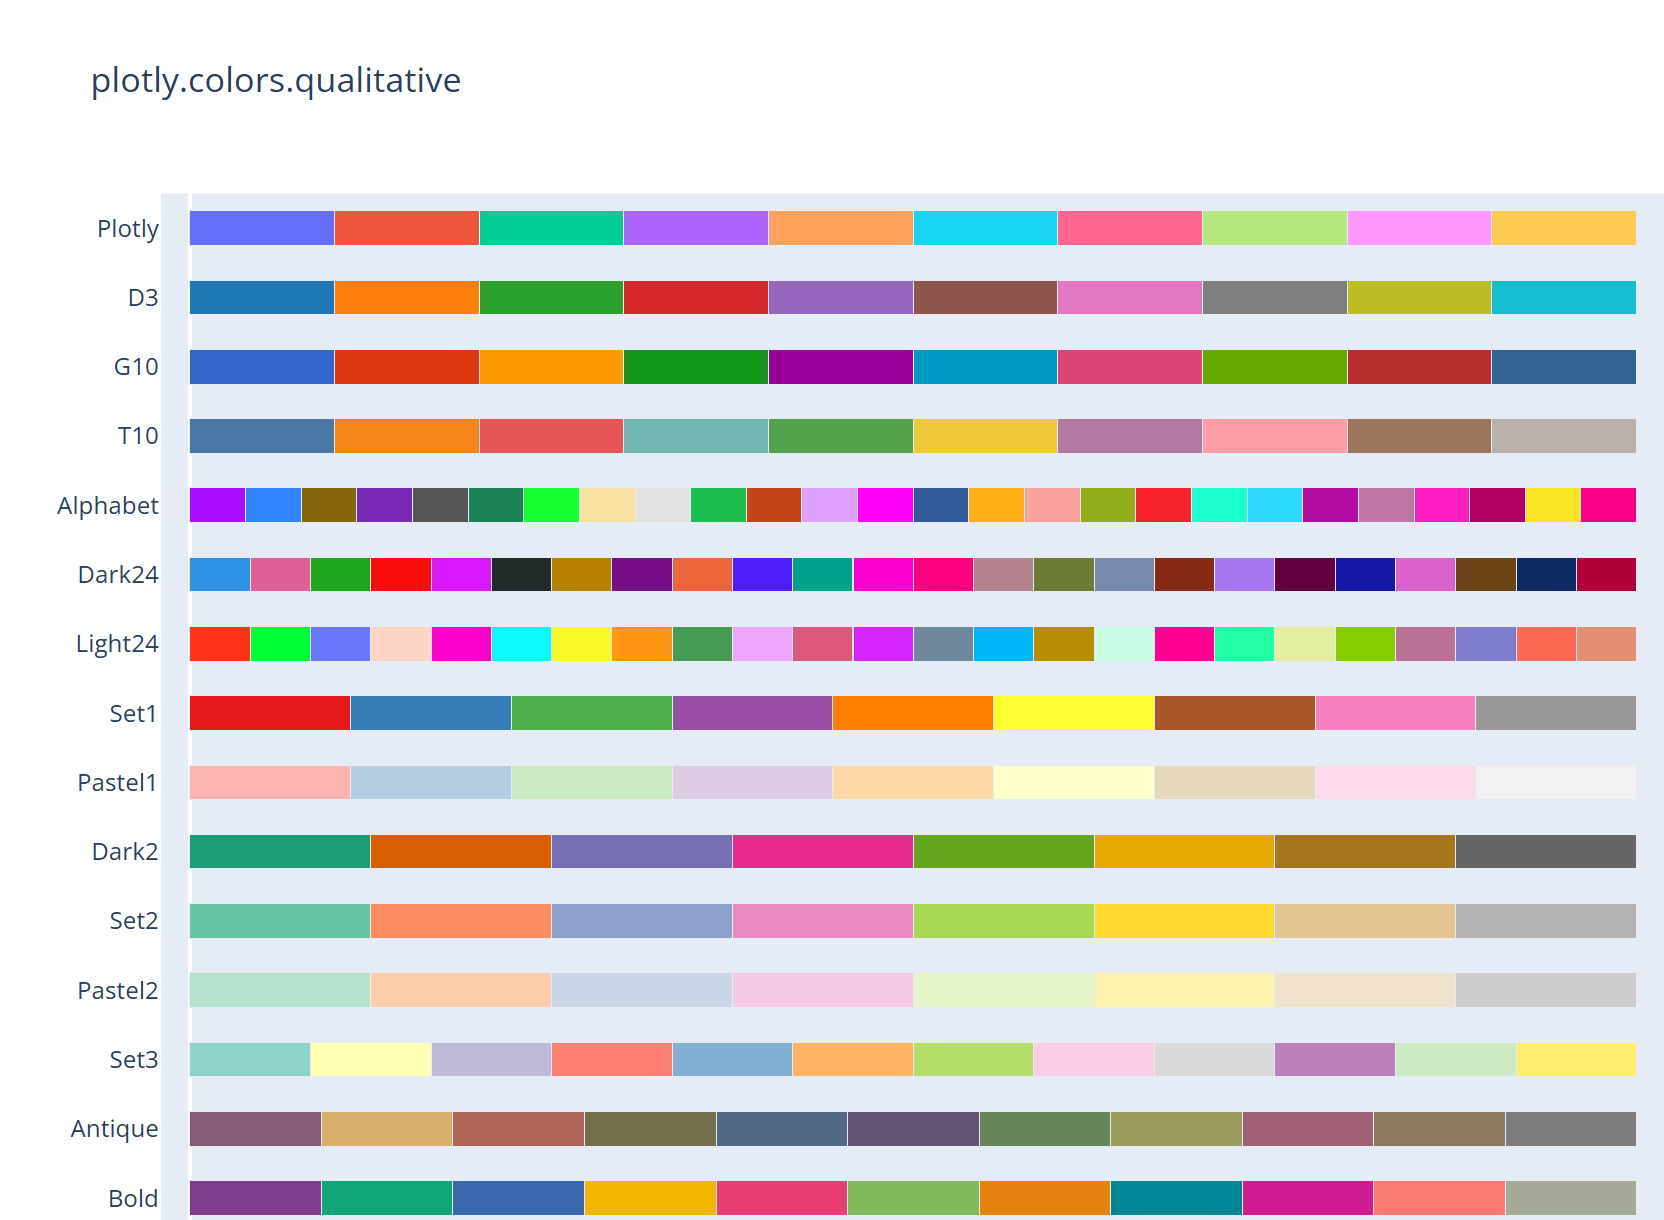

In [ ]:
import pandas as pd
import plotly.express as px
import numpy as np

# 1. 讀取資料
df = pd.read_csv('return_industry.csv')

# 清除可能存在的雜訊欄位
if 'Unnamed: 182' in df.columns:
    df = df.drop(columns=['Unnamed: 182'])

if '平均值' in df.columns:
    df = df.drop(columns=['平均值'])

# 2. 資料轉置：從 Wide Format 轉為 Long Format
# id_vars 是固定欄位 (產業名稱)，其餘欄位都是時間點
id_col = df.columns[0]  # 'TSE產業名稱'
time_cols = df.columns[1:]  # '-10', '-9', ... 等時間欄位

df_long = df.melt(id_vars=[id_col], value_vars=time_cols, var_name='Day', value_name='Return')

# 3. 資料清理：將天數轉為整數並排序
df_long['Day'] = df_long['Day'].astype(int)
df_long = df_long.sort_values(by=[id_col, 'Day'])

# 4. 計算累積報酬 (Trend Growth 的核心)
df_long['Cumulative_Return'] = df_long.groupby(id_col)['Return'].cumsum()

# 5. 製作動畫專用的資料結構 (Data Inflation)
# 為了讓線條有「生長」的效果，每一個 Frame (時間點) 必須包含「過去所有的資料」
frames_data = []
unique_days = sorted(df_long['Day'].unique())

for day in unique_days:
    # 篩選出「目前時間點之前」的所有資料
    subset = df_long[df_long['Day'] <= day].copy()
    subset['Frame'] = day  # 設定動畫的時間軸標記
    frames_data.append(subset)

# 合併所有 Frame 的資料 (這會使資料量變大，但能確保動畫流暢)
animated_df = pd.concat(frames_data)

distinct_colors = px.colors.qualitative.Alphabet + px.colors.qualitative.Dark24

# 6. 繪製動態折線圖 (加入 color_discrete_sequence)
fig = px.line(
    animated_df,
    x="Day",
    y="Cumulative_Return",
    color=id_col,
    animation_frame="Frame",
    title="各產業累積異常報酬率動態趨勢圖",
    labels={"Cumulative_Return": "Cumulative Abnormal Return (%)", "Day": "Event Day"},
    range_x=[min(unique_days), max(unique_days)],
    range_y=[df_long['Cumulative_Return'].min()*1.1, df_long['Cumulative_Return'].max()*1.1],
    
    # ★ 關鍵修改在這裡：指定自訂的超長色票
    color_discrete_sequence=distinct_colors
)

# 優化版面 (建議把 Legend 字體縮小，以免遮住圖表)
fig.update_layout(
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True),
    hovermode="x unified",
    legend=dict(
        font=dict(size=9), # 縮小圖例字體
        itemwidth=30       # 縮窄圖例寬度
    ),
    updatemenus=[dict(type='buttons', showactive=False,
                                buttons=[dict(label='Play',
                                            method='animate',
                                            args=[None, dict(frame=dict(duration=50, redraw=True), fromcurrent=True)])])]
)

fig.write_html("trend_growth_animation_v2.html")
print("已生成顏色改良版：trend_growth_animation_v2.html")

已生成顏色改良版：trend_growth_animation_v2.html


#### step 2 : 分別找出事件期內表現最好/最差的5個產業

#### 表現最好的5個產業 :  玻璃陶瓷 + 數位雲端 + 油電燃氣業 + 食品工業 + 農業科技
#### 表現最差的5個產業 :  存託憑證 (不太算產業吧) + 鋼鐵工業 + 通訊網路業 + 運動休閒 + 資訊服務業 + 汽車工業

In [12]:
if "Unnamed: 182" in return_industry.columns:
    return_industry=return_industry.drop(columns="Unnamed: 182")

if 0 in return_industry.columns:
    return_industry=return_industry.drop(columns=0)

return_industry_mean=return_industry.mean(axis=1)
return_industry["平均值"]=return_industry_mean
print("事件期內報酬率最高的5個產業:",return_industry_mean.sort_values(ascending=False).head().index)
print("事件期內報酬率最低的6個產業:",return_industry_mean.sort_values(ascending=True).head(6).index)



事件期內報酬率最高的5個產業: Index(['玻璃陶瓷', '數位雲端', '油電燃氣業', '食品工業', '農業科技'], dtype='object', name='TSE產業名稱')
事件期內報酬率最低的6個產業: Index(['存託憑證', '鋼鐵工業', '通訊網路業', '運動休閒', '資訊服務業', '汽車工業'], dtype='object', name='TSE產業名稱')


### 再針對最好以及最慘的產業製作動態累積報酬率變化圖

#### updatemenus 參數文件 : https://plotly.com/python/reference/layout/updatemenus/#layout-updatemenus

In [13]:
df_extreme_columns=['玻璃陶瓷', '數位雲端', '油電燃氣業', '食品工業', '農業科技','鋼鐵工業', '通訊網路業', '運動休閒', '資訊服務業', '汽車工業']
df_extreme=return_industry.loc[df_extreme_columns,:]

def plot_cumulative_return_animation(df, output_filename="trend_growth_animation.html", title="各產業累積異常報酬率動態趨勢圖"):
    """
    將寬表格格式的事件研究法資料，轉換為動態累積報酬率折線圖並輸出 HTML。
    
    參數:
    ----------
    df : pd.DataFrame
        原始寬表格資料。
        - 第 1 欄必須是 ID (如 'TSE產業名稱' 或 '公司代號')
        - 第 2 欄之後必須是時間序 (如 '-10', '-9', ... '0', '1' ...)
    output_filename : str
        輸出的 HTML 檔名 (預設: "trend_growth_animation.html")
    title : str
        圖表標題
        
    回傳:
    ----------
    fig : plotly.graph_objs._figure.Figure
        Plotly 的圖表物件 (可在 Jupyter Notebook 中直接顯示)
    """
    
    # 1. 自動辨識 ID 欄位與時間欄位
    id_col = df.columns[0]      # 抓取第一欄作為 ID (例如: 產業名稱)
    time_cols = df.columns[1:]  # 抓取其餘欄位作為時間 (例如: -10, -9...)
    
    print(f"正在處理資料... ID欄位: {id_col}, 時間欄位數: {len(time_cols)}")

    # 2. 寬轉長 (Melt)
    df_long = df.melt(id_vars=[id_col], value_vars=time_cols, var_name='Day', value_name='Return')

    # 3. 資料清理：轉整數並排序
    try:
        df_long['Day'] = df_long['Day'].astype(int)
    except ValueError:
        print("警告：時間欄位包含非數字字元，嘗試強制轉換...")
        # 這裡假設欄位是純數字字串，若有 'Day-1' 這種格式可能需要額外處理
        df_long['Day'] = pd.to_numeric(df_long['Day'], errors='coerce')
        
    df_long = df_long.sort_values(by=[id_col, 'Day'])

    # 4. 計算累積報酬 (CAR)
    # 注意：如果原本輸入的就已經是累積報酬，這一行會變成「累積的累積」，請確認輸入資料為「單日報酬」
    df_long['Cumulative_Return'] = df_long.groupby(id_col)['Return'].cumsum()

    # 5. 製作動畫資料結構 (Data Inflation)
    # 讓線條隨著 Frame 增加而變長，而不是只顯示單點
    frames_data = []
    unique_days = sorted(df_long['Day'].unique())

    print("正在生成動畫影格 (這可能需要一點時間)...")
    for day in unique_days:
        # 篩選出「目前時間點之前」的所有資料
        subset = df_long[df_long['Day'] <= day].copy()
        subset['Frame'] = day  # 設定動畫的時間軸標記
        frames_data.append(subset)

    # 合併資料
    animated_df = pd.concat(frames_data)

    # 定義色票 (避免顏色不夠用)
    distinct_colors = px.colors.qualitative.Alphabet + px.colors.qualitative.Dark24

    # 6. 繪圖
    fig = px.line(
        animated_df,
        x="Day",
        y="Cumulative_Return",
        color=id_col,
        animation_frame="Frame",
        title=title,
        labels={"Cumulative_Return": "Cumulative Abnormal Return (%)", "Day": "Event Day"},
        
        # 設定固定範圍，避免動畫播放時座標軸亂跳
        range_x=[min(unique_days), max(unique_days)],
        range_y=[df_long['Cumulative_Return'].min()*1.1, df_long['Cumulative_Return'].max()*1.1],
        
        # 指定色票
        color_discrete_sequence=distinct_colors
    )

    # 7. 優化版面
    fig.update_layout(
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True),
        hovermode="x unified",
        legend=dict(
            font=dict(size=9),
            itemwidth=30
        ),
        # 設定播放按鈕參數
        updatemenus=[dict(
            type='buttons', 
            showactive=False,
            buttons=[dict(
                label='Play',
                method='animate',
                args=[None, dict(frame=dict(duration=50, redraw=True), fromcurrent=True)]
            )]
        )]
    )

    # 8. 輸出結果
    fig.write_html(output_filename)
    print(f"✅ 成功生成動畫圖表：{output_filename}")
    
    return fig

In [28]:
df_extreme=df_extreme.reset_index()

In [29]:
plot_cumulative_return_animation(df_extreme, output_filename="trend_growth_animation_extreme5.html", title="最好/糟產業累積異常報酬率動態趨勢圖")

正在處理資料... ID欄位: TSE產業名稱, 時間欄位數: 132
警告：時間欄位包含非數字字元，嘗試強制轉換...
正在生成動畫影格 (這可能需要一點時間)...
✅ 成功生成動畫圖表：trend_growth_animation_extreme5.html


#### 觀察表現最好 / 最差產業與EPU多寡之間的關聯

In [23]:
# 需加入axis=1 ，否則預設值會以axis=0運作 (-10平均, -9平均....)
df_extreme_return_EPU=df_extreme.mean(axis=1)
df_fs_extreme_EPU=df_fs_return[df_fs_return["TSE產業名稱"].isin(df_extreme_columns)]
df_fs_extreme_EPU=df_fs_extreme_EPU.groupby(by="TSE產業名稱")["EPU數量_廣義"].mean()
df_extreme_return_EPU=pd.concat([df_extreme_return_EPU,df_fs_extreme_EPU],axis=1)


#### 變更欄位名稱

In [31]:
df_extreme_return_EPU.rename(columns={0:"平均報酬率"},inplace=True)
df_extreme_return_EPU.set_index("TSE產業名稱", inplace=True)
print(df_extreme_return_EPU.columns)

Index(['平均報酬率', 'EPU數量_廣義'], dtype='object')


### 抓取最好/最糟報酬率表現企業的EPU數量，製作熱力圖
### 目的 : 觀察EPU對企業市場表現影響的相關性
### 結果 : Pearson 相關係數 = -0.104 --> 不相關   Spearman 相關係數 = -0.0909 --> 不相關
### Pearson v.s Spearman 差別 : Pearson 僅考量線性關係 (計算線性關係外的數據會失準) ，Spearman則能呈現線性分布外的單調關係
#### 單調關係 = Xi 和 Yi 呈現正相關，但數據不一定是線性分布，其曲線根據斜率大小可能不一，線條有時急遽，有時趨緩，呈現S曲線
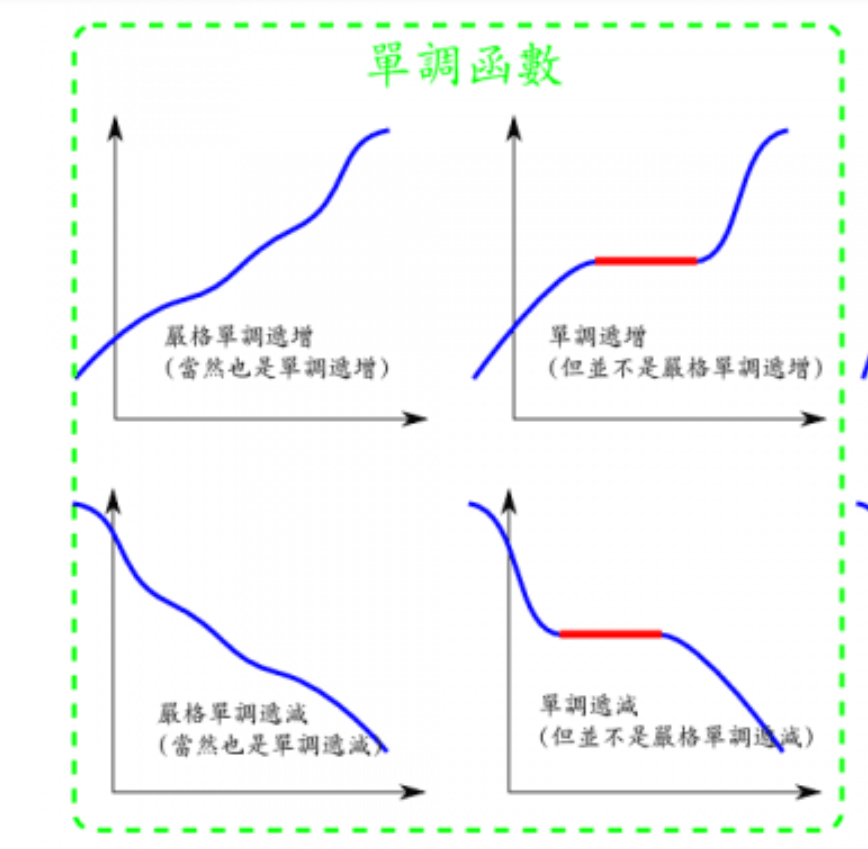

In [38]:
correlation_pearson = df_extreme_return_EPU['平均報酬率'].corr(df_extreme_return_EPU['EPU數量_廣義'],method="pearson")
correlation_spearman = df_extreme_return_EPU['平均報酬率'].corr(df_extreme_return_EPU['EPU數量_廣義'],method="spearman")

print(f"相關係數: {correlation_pearson:.4f}")
print(f"相關係數: {correlation_spearman:.4f}")

相關係數: -0.1014
相關係數: -0.0909


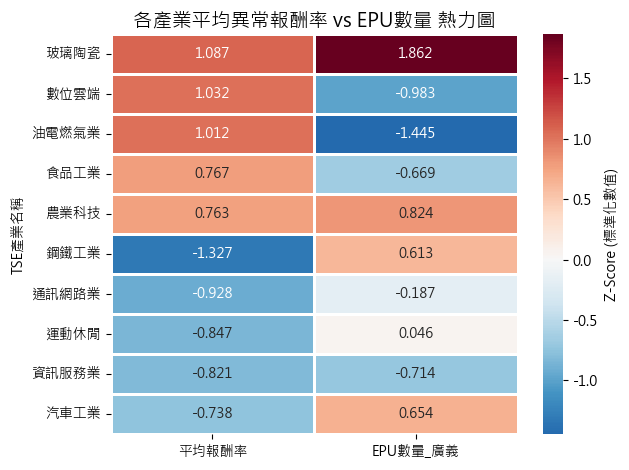

In [35]:
import matplotlib.pyplot as plt
df_norm = (df_extreme_return_EPU - df_extreme_return_EPU.mean()) / df_extreme_return_EPU.std()
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False # 解決負號無法顯示的問題

sns.heatmap(df_norm, 
            annot=df_norm,           # 在格子裡顯示「原始數值」
            fmt=".3f",          # 數值格式：小數點後3位
            cmap="RdBu_r",      # 色票：紅藍配色 (Red-Blue reversed)，紅色代表高值
            center=0,           # 將顏色中心點設為 0 (平均值)
            linewidths=1,       # 格子邊框寬度
            cbar_kws={'label': 'Z-Score (標準化數值)'} # 色條標籤
           )

plt.title("各產業平均異常報酬率 vs EPU數量 熱力圖", fontsize=14)
plt.yticks(rotation=0) # 讓y軸文字轉正
plt.tight_layout()
plt.show()

#### 用OLS模型進行迴歸分析

In [39]:
%pip install statsmodels

  Using cached patsy-1.0.2-py2.py3-none-any.whl.metadata (3.6 kB)
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.6 MB 8.5 MB/s eta 0:00:02
   --------- ------------------------------ 2.4/9.6 MB 7.5 MB/s eta 0:00:01
   --------------- ------------------------ 3.7/9.6 MB 7.3 MB/s eta 0:00:01
   -------------------- ------------------- 5.0/9.6 MB 6.7 MB/s eta 0:00:01
   -------------------------- ------------- 6.3/9.6 MB 6.5 MB/s eta 0:00:01
   ------------------------------- -------- 7.6/9.6 MB 6.4 MB/s eta 0:00:01
   ------------------------------------ --- 8.7/9.6 MB 6.4 MB/s eta 0:00:01
   ---------------------------------------- 9.6/9.6 MB 6.3 MB/s eta 0:00:00
Using cached patsy-1.0.2-py2.py3-none-any.whl (233 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
